In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[Q1 10 points] Read in data

In [55]:
#Read in individual files using pd.read_csv
gold = pd.read_csv('gold.txt',sep="\t",header=None, names=["url","category"])
labels = pd.read_table('labels.txt', sep="\t",header=None, names =['turk','url','category'])

In [56]:
#Gold data dimensions
gold.shape

(1517, 2)

In [57]:
#Check for duplicates
gold[['url']].drop_duplicates().shape

(1517, 1)

In [58]:
#Sample gold data
gold.iloc[:5]

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X


In [59]:
#Labels data dimensions
labels.shape

(92721, 3)

In [60]:
#Check for duplicates
labels[['turk','url','category']].drop_duplicates().shape

(89948, 3)

In [61]:
#Dropping duplicates to avaid providing additional weight for Turks that have observations repeated, thereby biasing odds
labels = labels[['turk','url','category']].drop_duplicates()

Say one turk-url-category combination is repeated 100 times. If we do not remove duplicates and we find the category validated in the gold set, the odds for this particular turk will rise significantly compared to other turks. To remove this bias we end up deduplicating the labels dataset.

In [62]:
#Labels data sample
labels.iloc[:5]

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G


[Q2 10 points] Split into two DataFrames

In [63]:
#Number of unique URLs in gold
gold['url'].nunique()

1517

In [64]:
#Number of unique URLs in label
labels['url'].nunique()

11040

In [65]:
#Subset of labels data in gold
url_in_gold_list = labels['url'][labels['url'].isin(gold['url'].unique())].unique()

In [66]:
#Length of unique urls in gold list
len(url_in_gold_list)

333

In [67]:
#Sample urls from gold list
url_in_gold_list[0:5]

array(['http://0800-horoscope.com', 'http://18games.net',
       'http://1pixelout.net', 'http://1porno.com/004/teens/index.html',
       'http://1stpussy.com/005/16/index.html'], dtype=object)

In [68]:
#Creating segregated dataframes for labels in gold vs not
labelongold = labels[labels['url'].isin(url_in_gold_list)]
labelsunknown = labels[~labels['url'].isin(url_in_gold_list)]

In [69]:
#Labels in gold data dimensions
labelongold.shape

(3319, 3)

In [70]:
#Labels unknown data dimensions
labelsunknown.shape

(86629, 3)

[Q3 10 points] Compute accuracies of turks

In [71]:
#Left join gold into labels dataset
turks_merged = labels.merge(gold,how="left",on = "url",suffixes=["_turks","_gold"])
turks_merged.shape

(89948, 4)

In [72]:
turks_merged[0:5]

,turk,url,category_turks,category_gold
0,A1OT3A29R9N1DG,http://000.cc,P,NaN
1,A1PXXEOGQ76RNJ,http://000.cc,G,NaN
2,A21US576U8SCO4,http://000.cc,G,NaN
3,A2LGX47NN7C5D3,http://000.cc,G,NaN
4,A2OVKTB7VNY8EW,http://000.cc,G,NaN


In [73]:
#Subset out NaNs from category_gold column to get inner join, original df is not changed if left join is needed later on
turks_merged_sub = turks_merged.dropna(subset = ['category_gold'])
turks_merged_sub[0:5]

,turk,url,category_turks,category_gold
224,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G
225,A153PKAL7OAY36,http://0800-horoscope.com,G,G
226,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G
227,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G
228,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G


In [74]:
turks_merged_sub.shape

(3319, 4)

In [75]:
#Create another column with boolean output for whether both data category columns match or not
turks_merged_sub.loc[:,'isMatch'] = (turks_merged_sub['category_turks']==turks_merged_sub['category_gold']).astype(int).copy()

In [76]:
#Number of matches
turks_merged_sub['isMatch'].sum()

2262

In [77]:
#Define ratergoodness as specified
rater_goodness = turks_merged_sub.groupby(['turk'])['isMatch'].agg(['count','mean']).round(5)
rater_goodness[0:10]

,count,mean
turk,,
A112DVP1KG4QZU,1,1.00000
A1253FXHCZ9CWM,29,0.51724
A12CY1Q7XKJJDE,1,1.00000
A12RE8G66WTO8B,20,0.75000
A12Y1GTGIQDGRA,3,0.33333
A13CEW9JGDWGX1,1,1.00000
A13OE9GBRJ0S2U,4,0.75000
A14IQ4GLNWNPOJ,1,1.00000
A153PKAL7OAY36,148,0.72297


[Q4 10 points] Odds ratios

In [78]:
#Rater goodness dimensions
rater_goodness.shape

(269, 2)

In [79]:
#Define odds column
rater_goodness['odds'] = rater_goodness['mean'].map(lambda x : ((x)/(1.001 - x)))

<AxesSubplot:ylabel='Frequency'>

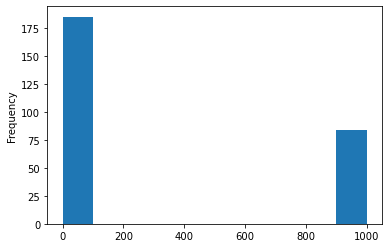

In [80]:
rater_goodness['odds'].plot(kind='hist')

[Q5 10 points] Most accurate turks

In [81]:
#Filter for count more than 20 and sort turks by odds
rater_goodness[rater_goodness['count'] >= 20].sort_values('odds',ascending = False)[0:10]

,count,mean,odds
turk,,,
A2U0R4X38GUKZE,20,0.95000,18.627451
A22C0PJUBFJTI0,36,0.91667,10.870034
A23YQUBXZPKILZ,24,0.87500,6.944444
ATVALOQVDCMZW,103,0.85437,5.826707
A1HIXWH4OXT8S4,40,0.82500,4.687500
A3220HG1O83HQ4,22,0.81818,4.475331
A32W20KGQXS0LL,25,0.80000,3.980100
A20PWAB7G3HDHU,20,0.80000,3.980100
AJSJVK40F5HM6,28,0.78571,3.649542


In [82]:
#List out top rated turks by invoking index of df
rater_goodness[rater_goodness['count'] >= 20].sort_values('odds',ascending = False)[0:10].index.values

array(['A2U0R4X38GUKZE', 'A22C0PJUBFJTI0', 'A23YQUBXZPKILZ',
       'ATVALOQVDCMZW', 'A1HIXWH4OXT8S4', 'A3220HG1O83HQ4',
       'A32W20KGQXS0LL', 'A20PWAB7G3HDHU', 'AJSJVK40F5HM6',
       'A31OCN4MNHUQ6W'], dtype=object)

[Q6 10 points] Rating counts versus accuracy

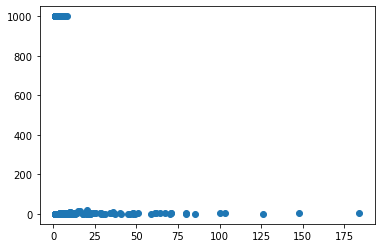

In [30]:
#Plot of count vs odds
scatter(rater_goodness['count'] , rater_goodness['odds'] , marker='o')

We see large outlier values of odds such as 1000 at lower values of counts (odds here will be very sensitive to fluctuations)

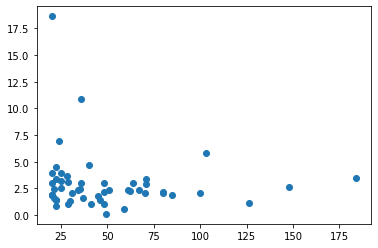

In [31]:
#Outlier removal -- assumption is odds of raters with count less than 20 is too volatile and need not be included
rater_goodness_sub = rater_goodness[rater_goodness['count'] >=20 ].sort_values('odds',ascending = False)
scatter(rater_goodness_sub['count'] , rater_goodness_sub['odds'] , marker='o')

In [32]:
#Quantile approach on raw data
rater_goodness['Odds_qcut'] = pd.qcut(rater_goodness['odds'] , q = 3)

In [33]:
rater_goodness.groupby('Odds_qcut')[['count']].agg('mean')

,count
Odds_qcut,
"(-0.001, 1.441]",8.153846
"(1.441, 8.911]",26.055556
"(8.911, 1000.0]",2.636364


We see that the category of odds between 1.441 to 8.911 have the highest number of average rater counts. Other tertiles such as 0 to 1.441 on the lower end had almost a third of average rater counts whereas last tertile 8.911 to 1000 has average rater count of only 2. As stated above this could be due to high volatility in odds for raters with less numbers of ratings

In [34]:
#Quantile approach on filtered data
rater_goodness_sub['Odds_qcut'] = pd.qcut(rater_goodness_sub['odds'] , q = 3)

In [35]:
rater_goodness_sub.groupby('Odds_qcut')[['count']].agg('mean')

,count
Odds_qcut,
"(0.113, 1.925]",41.222222
"(1.925, 2.988]",57.600000
"(2.988, 18.627]",46.357143


Upon removing outliers we see trend with similar directionality with middle odds tertile having most number of average rater counts, however other tertiles have number of rater counts in the comparable range now (~80 percent of average rater counts in middle tertile)

<AxesSubplot:xlabel='count', ylabel='odds'>

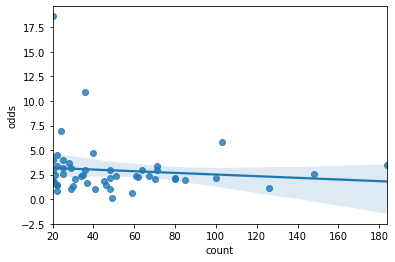

In [36]:
#Fitting a regression line on filtered data
sns.regplot(x="count",
            y="odds", 
            data=rater_goodness_sub)


Upon removing outliers with low number of counts (less than 20) that give out highly volatile odds, we see a very small negative correlation between number of questions and odds.

In case you keep low values of n counts in your data and only remove outliers based on say odds > 500 or so, you can avail a positive correlation but it's not trustworthy due to higher volatility of odds for low values of count

[Q7 13 points] Overall predicted odds

In [37]:
#Extract top 25 percentile of raters from rater goodness since it already includes all raters with atleast 1 gold rater
top_25_raters_df = rater_goodness[rater_goodness['count'] > rater_goodness['count'].quantile(0.75)].reset_index()

#Merge df with labels unknown  -- inner join would directly filter out data for all relevant turks
labelsunknown_top25 = labelsunknown.merge(top_25_raters_df[['turk','count','odds']],on="turk")

#Summarize prod of odds by groupby on label unknown url and category
labelsunknown_top25_summ = labelsunknown_top25.groupby(['url','category'])[['odds']].prod()

In [38]:
labelsunknown_top25_summ

odds
url                         category           
http://0-101.net            G          2.297658
http://000.cc               G          1.485507
http://0000.jp              G         14.339220
http://000relationships.com G          3.842040
                            P          1.851852
...                                         ...
http://zynga.com            G          3.666515
http://zz868.com            G          1.047872
                            P          1.851852
http://zzx.cc               G          1.417641
                            X          1.620762

[13983 rows x 1 columns]

Above grouped table shows necessary output with all label unknown url and categories groupes and juxtaposed with corresponding product of odds of reliables turks.

[Q8 13 points] Predicted categories

In [39]:
labelsunknown_top25_summ

odds
url                         category           
http://0-101.net            G          2.297658
http://000.cc               G          1.485507
http://0000.jp              G         14.339220
http://000relationships.com G          3.842040
                            P          1.851852
...                                         ...
http://zynga.com            G          3.666515
http://zz868.com            G          1.047872
                            P          1.851852
http://zzx.cc               G          1.417641
                            X          1.620762

[13983 rows x 1 columns]

In [40]:
#Reset index to make indices into columns
labelsunknown_top25_summ_ri = labelsunknown_top25_summ.reset_index()

In [41]:
#Add a column of max per grouped segment
labelsunknown_top25_summ_ri['odds_max'] = labelsunknown_top25_summ_ri.groupby(['url'])['odds'].transform(max)

In [42]:
#Subset values where odds = max.odds
(labelsunknown_top25_summ_ri)

,url,category,odds,odds_max
0,http://0-101.net,G,2.297658,2.297658
1,http://000.cc,G,1.485507,1.485507
2,http://0000.jp,G,14.339220,14.339220
3,http://000relationships.com,G,3.842040,3.842040
4,http://000relationships.com,P,1.851852,3.842040
...,...,...,...,...
13978,http://zynga.com,G,3.666515,3.666515
13979,http://zz868.com,G,1.047872,1.851852
13980,http://zz868.com,P,1.851852,1.851852
13981,http://zzx.cc,G,1.417641,1.620762


In [43]:
#Subset where odds = max odds
result75 = labelsunknown_top25_summ_ri[labelsunknown_top25_summ_ri['odds'] == labelsunknown_top25_summ_ri['odds_max']]
result75

,url,category,odds,odds_max
0,http://0-101.net,G,2.297658,2.297658
1,http://000.cc,G,1.485507,1.485507
2,http://0000.jp,G,14.339220,14.339220
3,http://000relationships.com,G,3.842040,3.842040
5,http://000vitamins.com,G,4.033669,4.033669
...,...,...,...,...
13976,http://zwinky.com,G,17.201518,17.201518
13977,http://zylom.com,G,1.849595,1.849595
13978,http://zynga.com,G,3.666515,3.666515
13980,http://zz868.com,P,1.851852,1.851852


In [44]:
#Check whether dataframe is unique at url level
len(result75.url.unique())

10610

In [45]:
#This implies we have few url-category combinations with same max odds -- for simplicity we can randomly drop duplicates by choosing one category randomly
result75 = result75.drop_duplicates("url")
result75

,url,category,odds,odds_max
0,http://0-101.net,G,2.297658,2.297658
1,http://000.cc,G,1.485507,1.485507
2,http://0000.jp,G,14.339220,14.339220
3,http://000relationships.com,G,3.842040,3.842040
5,http://000vitamins.com,G,4.033669,4.033669
...,...,...,...,...
13976,http://zwinky.com,G,17.201518,17.201518
13977,http://zylom.com,G,1.849595,1.849595
13978,http://zynga.com,G,3.666515,3.666515
13980,http://zz868.com,P,1.851852,1.851852


[Q9 14 points] Predicted categories using more turks

In [46]:
#Extract top 75 percentile of raters from rater goodness since it already includes all raters with atleast 1 gold rater
top_75_raters_df = rater_goodness[rater_goodness['count'] > rater_goodness['count'].quantile(0.25)].reset_index()

#Merge df with labels unknown  -- inner join would directly filter out data for all relevant turks
labelsunknown_top75 = labelsunknown.merge(top_75_raters_df[['turk','count','odds']],on="turk")

#Summarize prod of odds by groupby on label unknown url and category
labelsunknown_top75_summ = labelsunknown_top75.groupby(['url','category'])[['odds']].prod()

#Reset index to make indices into columns
labelsunknown_top75_summ_ri = labelsunknown_top75_summ.reset_index()

labelsunknown_top75_summ_ri

,url,category,odds
0,http://0-101.net,G,2.297658e+00
1,http://000.cc,G,2.218267e+03
2,http://000.cc,P,9.980040e-01
3,http://0000.jp,G,2.847906e+07
4,http://000relationships.com,G,0.000000e+00
...,...,...,...
16685,http://zz868.com,G,1.209590e+13
16686,http://zz868.com,P,1.851852e+00
16687,http://zzx.cc,G,1.417641e+00
16688,http://zzx.cc,P,9.980040e-01


In [47]:
#Add a column of max per grouped segment
labelsunknown_top75_summ_ri['odds_max'] = labelsunknown_top75_summ_ri.groupby(['url'])['odds'].transform(max)

In [48]:
#Subset where odds = max odds
result25 = labelsunknown_top75_summ_ri[labelsunknown_top75_summ_ri['odds'] == labelsunknown_top75_summ_ri['odds_max']]
result25 = result25.drop_duplicates("url")
result25

,url,category,odds,odds_max
0,http://0-101.net,G,2.297658e+00,2.297658e+00
1,http://000.cc,G,2.218267e+03,2.218267e+03
3,http://0000.jp,G,2.847906e+07,2.847906e+07
5,http://000relationships.com,P,1.851852e+00,1.851852e+00
7,http://000vitamins.com,G,5.343501e+00,5.343501e+00
...,...,...,...,...
16682,http://zwinky.com,P,1.000000e+03,1.000000e+03
16683,http://zylom.com,G,3.062198e+03,3.062198e+03
16684,http://zynga.com,G,5.386065e+01,5.386065e+01
16685,http://zz868.com,G,1.209590e+13,1.209590e+13


In [49]:
result75.shape

(10610, 4)

In [50]:
result25.shape

(10700, 4)

In [51]:
#Making outer join 
all_res = result75.merge(result25,on=['url'],suffixes=['_75','_25'], how="outer")

In [52]:
all_res

,url,category_75,odds_75,odds_max_75,category_25,odds_25,odds_max_25
0,http://0-101.net,G,2.297658,2.297658,G,2.297658e+00,2.297658e+00
1,http://000.cc,G,1.485507,1.485507,G,2.218267e+03,2.218267e+03
2,http://0000.jp,G,14.339220,14.339220,G,2.847906e+07,2.847906e+07
3,http://000relationships.com,G,3.842040,3.842040,P,1.851852e+00,1.851852e+00
4,http://000vitamins.com,G,4.033669,4.033669,G,5.343501e+00,5.343501e+00
...,...,...,...,...,...,...,...
10695,http://twittas.com,NaN,NaN,NaN,G,9.960120e-01,9.960120e-01
10696,http://twitteronlinesystem.com,NaN,NaN,NaN,G,2.983613e+00,2.983613e+00
10697,http://wazap.com,NaN,NaN,NaN,G,2.641564e+03,2.641564e+03
10698,http://xt.to,NaN,NaN,NaN,G,9.980040e-01,9.980040e-01


In [53]:
pd.crosstab(all_res['category_75'] , all_res['category_25'])

category_25,G,P,R,X
category_75,,,,
G,8280,586,180,214
P,196,352,52,25
R,22,34,127,25
X,28,5,28,456
